# Coupled Decomposition - Part II

In [2]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs

# A method to resize the images on the fly.
from scipy.misc import imresize

# Fundamental matrix computation
from autocnet.transformation import fundamental_matrix as fm

from autocnet.transformation.decompose import coupled_decomposition
from scipy.spatial.distance import cdist

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## CandidateGraph -> Custom Extraction Func -> Matching -> Coupled Decomposition

In [3]:
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Enable the GPU
autocnet.cuda(enable=True, gpu=0)

In [4]:
# Write a custom keypoint extraction function - this could get monkey patched onto the graph object...
def extract(arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr0.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    return kp, des, sd, downsample_amount, arr

In [5]:
# Write a generic decomposer
def custom_decompose(arr0, arr1):
    kp0, des0, sd0, downsample_amount0, arr0 = extract(arr0, thresh=1)
    kp1, des1, sd1, downsample_amount1, arr1 = extract(arr1, thresh=1)

    # Now apply matching, outlier detection, and compute a fundamental matrix
    sd0 = cs.PySiftData.from_data_frame(kp0, des0)
    sd1 = cs.PySiftData.from_data_frame(kp1, des1)

    # Apply the matcher
    cs.PyMatchSiftData(sd0, sd1)
    matches, _ = sd0.to_data_frame()
    # Generic decision about ambiguity and score based on quantiles
    
    ambiguity_threshold = matches.ambiguity.quantile(0.01)  # Grabbing the 1%s in this data set
    score = matches.score.quantile(0.85)
    
    print(ambiguity_threshold, score)
    
    submatches = matches.query('ambiguity <= {} and score >= {}'.format(ambiguity_threshold, score))
    
    kpa = submatches[['x','y']]
    kpb = submatches[['match_xpos', 'match_ypos']]

    F, mask = fm.compute_fundamental_matrix(kpa, kpb, method='ransac', reproj_threshold=2.0)
    F = fm.enforce_singularity_constraint(F)

    inliers = submatches[mask]
    

    return inliers, arr0, arr1
    
arr0 = cg.node[0].geodata.read_array()
arr1 = cg.node[1].geodata.read_array()

inliers, arr0, arr1 = custom_decompose(arr0, arr1)

0.9287434983253479 0.9619517207145691


## Checking the Results

Now check the quality of our automated correspondence outlier thresholds - is the automated approach working?

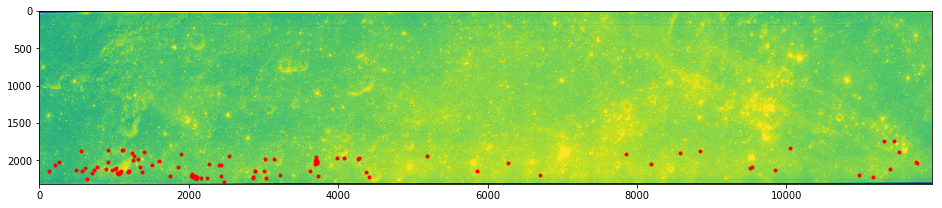

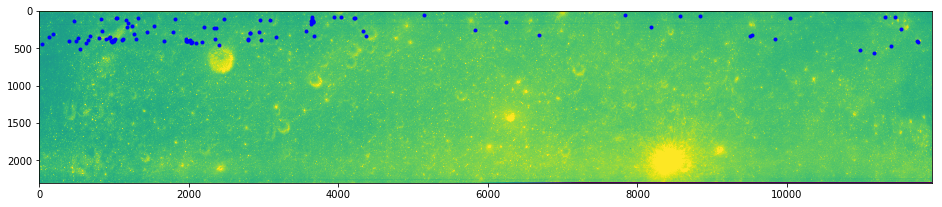

In [6]:
imshow(arr0)
plot(inliers.x, inliers.y, 'ro', markersize=3)
show()
imshow(arr1)
plot(inliers.match_xpos, inliers.match_ypos, 'bo', markersize=3)

## Extension
Now extend the custom decomposition func above to apply the decomposition method to the data.

In [7]:
# Write a generic decomposer
def custom_decompose(arr0, arr1):
    kp0, des0, sd0, downsample_amount0, arr0 = extract(arr0, thresh=1)
    kp1, des1, sd1, downsample_amount1, arr1 = extract(arr1, thresh=1)

    # Now apply matching, outlier detection, and compute a fundamental matrix
    sd0 = cs.PySiftData.from_data_frame(kp0, des0)
    sd1 = cs.PySiftData.from_data_frame(kp1, des1)

    # Apply the matcher
    cs.PyMatchSiftData(sd0, sd1)
    matches, _ = sd0.to_data_frame()
    # Generic decision about ambiguity and score based on quantiles
    
    # Apply outlier detection methods for the matches
    ambiguity_threshold = matches.ambiguity.quantile(0.01)  # Grabbing the 1%s in this data set
    score = matches.score.quantile(0.85)
    submatches = matches.query('ambiguity <= {} and score >= {}'.format(ambiguity_threshold, score))
    
    # Compute a fundamental matrix
    kpa = submatches[['x','y']]
    kpb = submatches[['match_xpos', 'match_ypos']]
    F, mask = fm.compute_fundamental_matrix(kpa, kpb, method='ransac', reproj_threshold=2.0)
    F = fm.enforce_singularity_constraint(F)

    # Grab the inliers
    inliers = submatches[mask]
    
    # Prepare for coupled decomposition
    midx = arr0.shape[1] / 2
    midy = arr0.shape[0] / 2

    mid = np.array([[midx, midy]])
    dists = cdist(mid, inliers[['x', 'y']])
    mid_correspondence = inliers.iloc[np.argmin(dists)]
    mid_correspondence

    # Decompose the images into quadrants
    smembership, dmembership, = coupled_decomposition(arr0, arr1,
                                                 sorigin=mid_correspondence[['x', 'y']],
                                                 dorigin=mid_correspondence[['match_xpos', 'match_ypos']],
                                                 theta=0)
    
    # Return the membership decisions
    return smembership, dmembership, arr0, arr1
    
arr0 = cg.node[0].geodata.read_array()
arr1 = cg.node[1].geodata.read_array()

# Keep returning arr0 and arr1 because MatPlotLib will crash the kernel if we try to visualize a non-downsampled version of the image.
smem, dmem, arr0, arr1 = custom_decompose(arr0, arr1)

## Checking Again
That the decomposition looks reasonably close.  The next step is to recursively apply the decomposition.

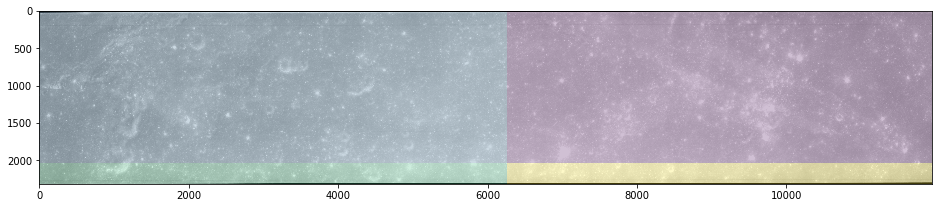

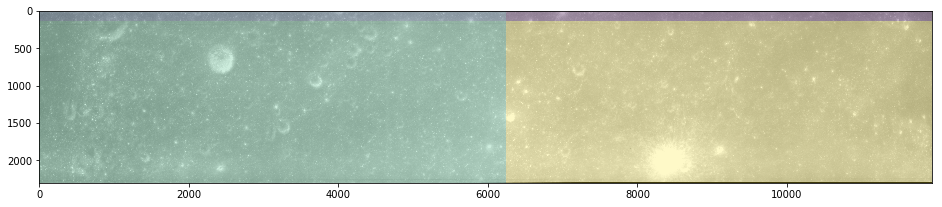

In [8]:
imshow(arr0, cmap='gray')
imshow(smem, alpha=0.25)
show()
imshow(arr1, cmap='gray')
imshow(dmem, alpha=0.25)
